In [15]:
import DGM
import tensorflow as tf
import numpy as np
import scipy.stats as spstats
import matplotlib.pyplot as plt

from dadi import Numerics, PhiManip, Integration, Spectrum

In [16]:
# PDE domain
t_low = 0 + 10e-15    # time lower bound
T = 1 - 10e-15 # time upper bound
x_low = 0.0 + 10e-15  # X lower bound
x_high = 1 - 10e-15   # X upper bound

num_layers = 3
nodes_per_layer = 20

tf.reset_default_graph()

# Load saved model
t_interior_tnsr = tf.placeholder(tf.float64, [None,1])
x_interior_tnsr = tf.placeholder(tf.float64, [None,1])

param_gamma_tnsr = tf.placeholder(tf.float64, [None, 1])
param_theta_tnsr = tf.placeholder(tf.float64, [None, 1])
param_nu_tnsr = tf.placeholder(tf.float64, [None, 1])

sess = tf.Session()

model = DGM.DGMNet(nodes_per_layer, num_layers, 1, 3)
V = model(t_interior_tnsr, [x_interior_tnsr], [param_gamma_tnsr, param_theta_tnsr, param_nu_tnsr])

saver = tf.train.Saver()
saver.restore(sess, "trained_models/one_pop_example")

INFO:tensorflow:Restoring parameters from trained_models/one_pop_example
INFO:tensorflow:Restoring parameters from trained_models/one_pop_example


In [17]:
# Initial solution
def WrightFisherInitial(x, theta, gamma, nu):
    return nu * theta*(1-np.exp(-2*gamma*(1-x)))/(1-np.exp(-2*gamma))

In [18]:
#dadi solution
def CalcDadi(x_grid, initial_phi,p_t, p_gamma, p_theta, p_nu):
    phi = Integration.one_pop(initial_phi, x_grid, p_t, nu = p_nu, gamma = p_gamma, theta0 = p_theta, beta=1)
    return phi

#Deep galerkin solution
def CalcDGM(t,  p_gamma, p_theta, p_nu):
    x_plot = np.linspace(x_low + 10e-3, x_high - 10e-3, 1000)
    t_plot = t * np.ones_like(x_plot.reshape(-1,1))
    u = sess.run([V], feed_dict= {t_interior_tnsr:t_plot, 
                                                    x_interior_tnsr:x_plot.reshape(-1,1),
                                                    param_gamma_tnsr:p_gamma * np.ones_like(x_plot.reshape(-1,1)),
                                                    param_theta_tnsr:p_theta * np.ones_like(x_plot.reshape(-1,1)),
                                                    param_nu_tnsr:p_nu * np.ones_like(x_plot.reshape(-1,1))})
    return u[0].reshape(1,-1)[0]/(x_plot*(1-x_plot))

In [19]:
def PlotSolutions(theta, gamma, nu, plot_afs = False):
    # LaTeX rendering for text in plots
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')

    # figure options
    plt.figure()
    plt.figure(figsize = (50,10))

    if(plot_afs):
        plt.suptitle(f'AFS plots, PDE parameters: $\\theta$ = {theta}, $\gamma$ = {gamma}, $\\nu$ = {nu}', fontsize=27)
    else:
        plt.suptitle(f'Density function $f(x,t)$ plots, PDE parameters: $\\theta$ = {theta}, $\gamma$ = {gamma}, $\\nu$ = {nu}', fontsize=27)

    times = [0, 0.1, 0.2, 0.5]

    x_plot = np.linspace(x_low + 10e-3, x_high - 10e-3, 1000)

    for i, curr_t in enumerate(times):

        # specify subplot
        plt.subplot(1,4,i+1)
        
        initial_u = WrightFisherInitial(x_plot, theta, gamma, nu)
        initial_phi = initial_u.reshape(1,-1)[0]/(x_plot*(1-x_plot))
        dadi_solution = CalcDadi(x_plot, initial_phi, curr_t, gamma, theta, nu)  
        dgm_solution = CalcDGM(curr_t, gamma, theta, nu)
        
        spectrum_dadi = Spectrum.from_phi(dadi_solution.reshape(1,-1)[0][5:-5], (50,), (x_plot[5:-5],))[2:-2]
        spectrum_dgm = Spectrum.from_phi(dgm_solution.reshape(1,-1)[0][5:-5], (50,), (x_plot[5:-5],))[2:-2]

        if(plot_afs):
            plt.semilogy(spectrum_dadi, '-og', label='Dadi')
            plt.semilogy(spectrum_dgm, '-ob', label='DGM')
            rmse = np.sqrt(((spectrum_dadi - spectrum_dgm)**2).mean())
            plt.title(f"AFS for $t = {curr_t}, RMSE: {round(rmse,2)}$", fontsize=24, y=1.03)
        else:
            plt.plot(x_plot, initial_phi, color = 'r', label='Initial solution', linewidth = 3, linestyle=':')
            plt.plot(x_plot, dgm_solution, color = 'b', label='DGM estimate')    
            plt.plot(x_plot, dadi_solution, color = 'g', label='Dadi estimate')    
            rmse = np.sqrt(((dadi_solution[100:-100] - dgm_solution[100:-100])**2).mean())
            plt.title(f"$f(x, t = {curr_t}), RMSE: {round(rmse,2)}$", fontsize=24, y=1.03)
            plt.ylim(ymin=0, ymax=500)
            plt.xlim(xmin=0, xmax=1)
            plt.xlabel(r"x", fontsize=15, labelpad=10)
            plt.ylabel(r"Frequency spectrum, f(x,t)", fontsize=15, labelpad=20)

        plt.xticks(fontsize=13)
        plt.yticks(fontsize=13)
        plt.grid(linestyle=':')
        
        if i == 0:
            plt.legend(loc='upper left', prop={'size': 16})

    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.show()

## $\theta = 1.0$

### $\gamma = 1.3, \nu = 40.0$

<Figure size 432x288 with 0 Axes>

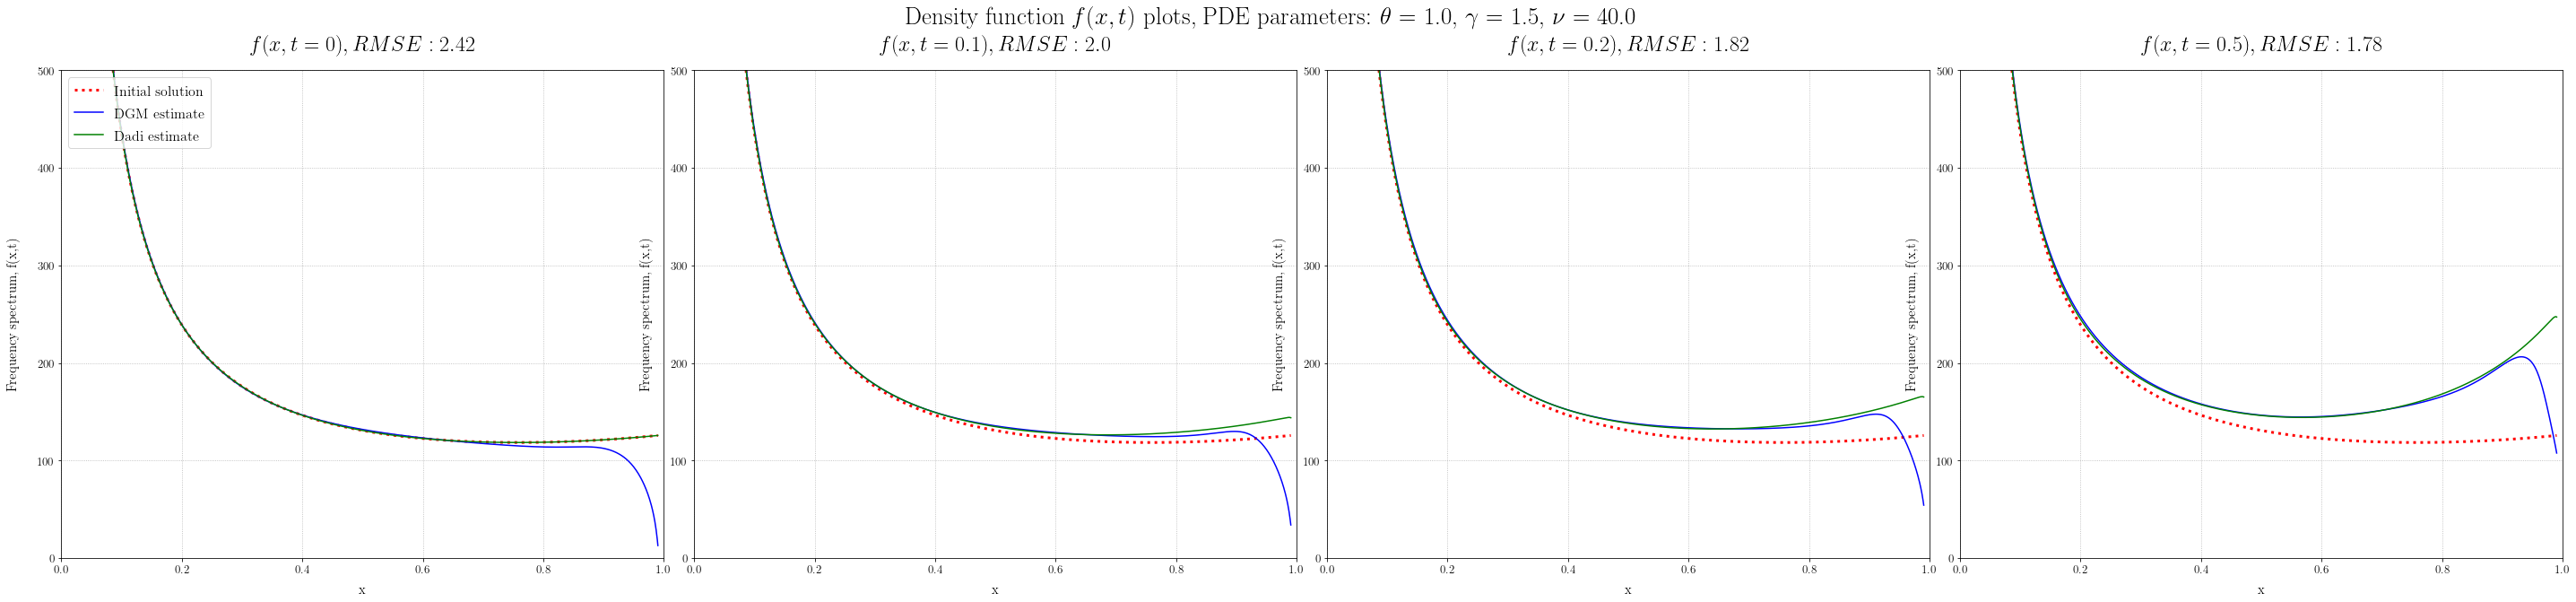

<Figure size 432x288 with 0 Axes>

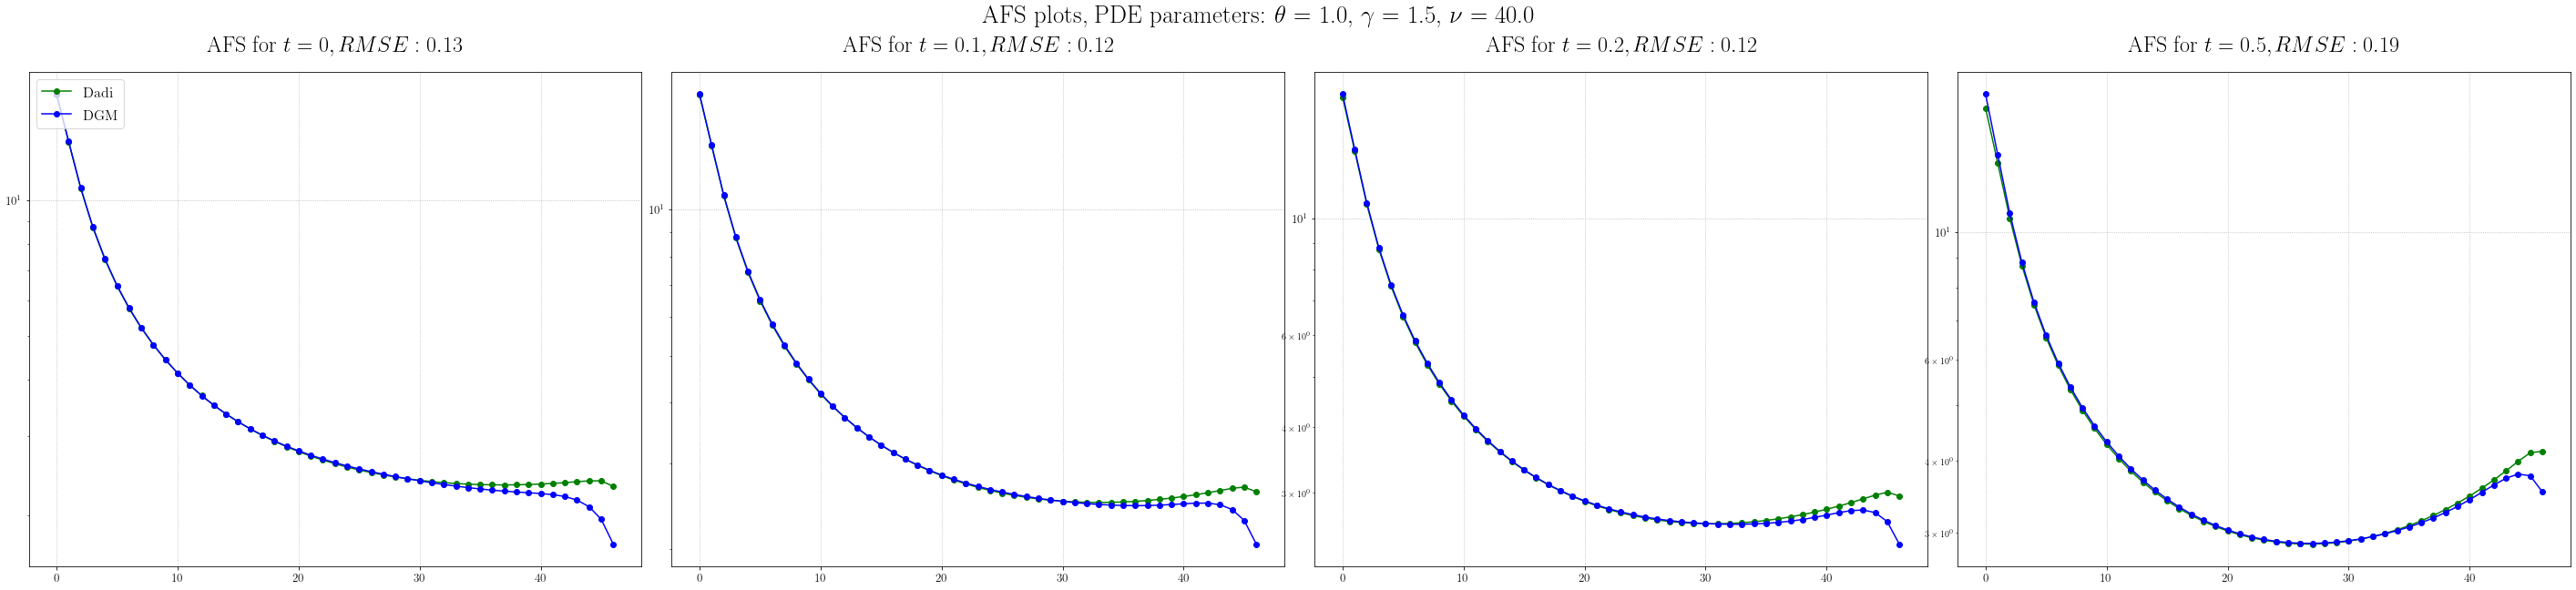

In [21]:
PlotSolutions(theta = 1.0, gamma =  1.5, nu = 40.0)
PlotSolutions(1.0, 1.5, 40.0, plot_afs=True)

### $\gamma = 1.3, \nu = 44.0$

<Figure size 432x288 with 0 Axes>

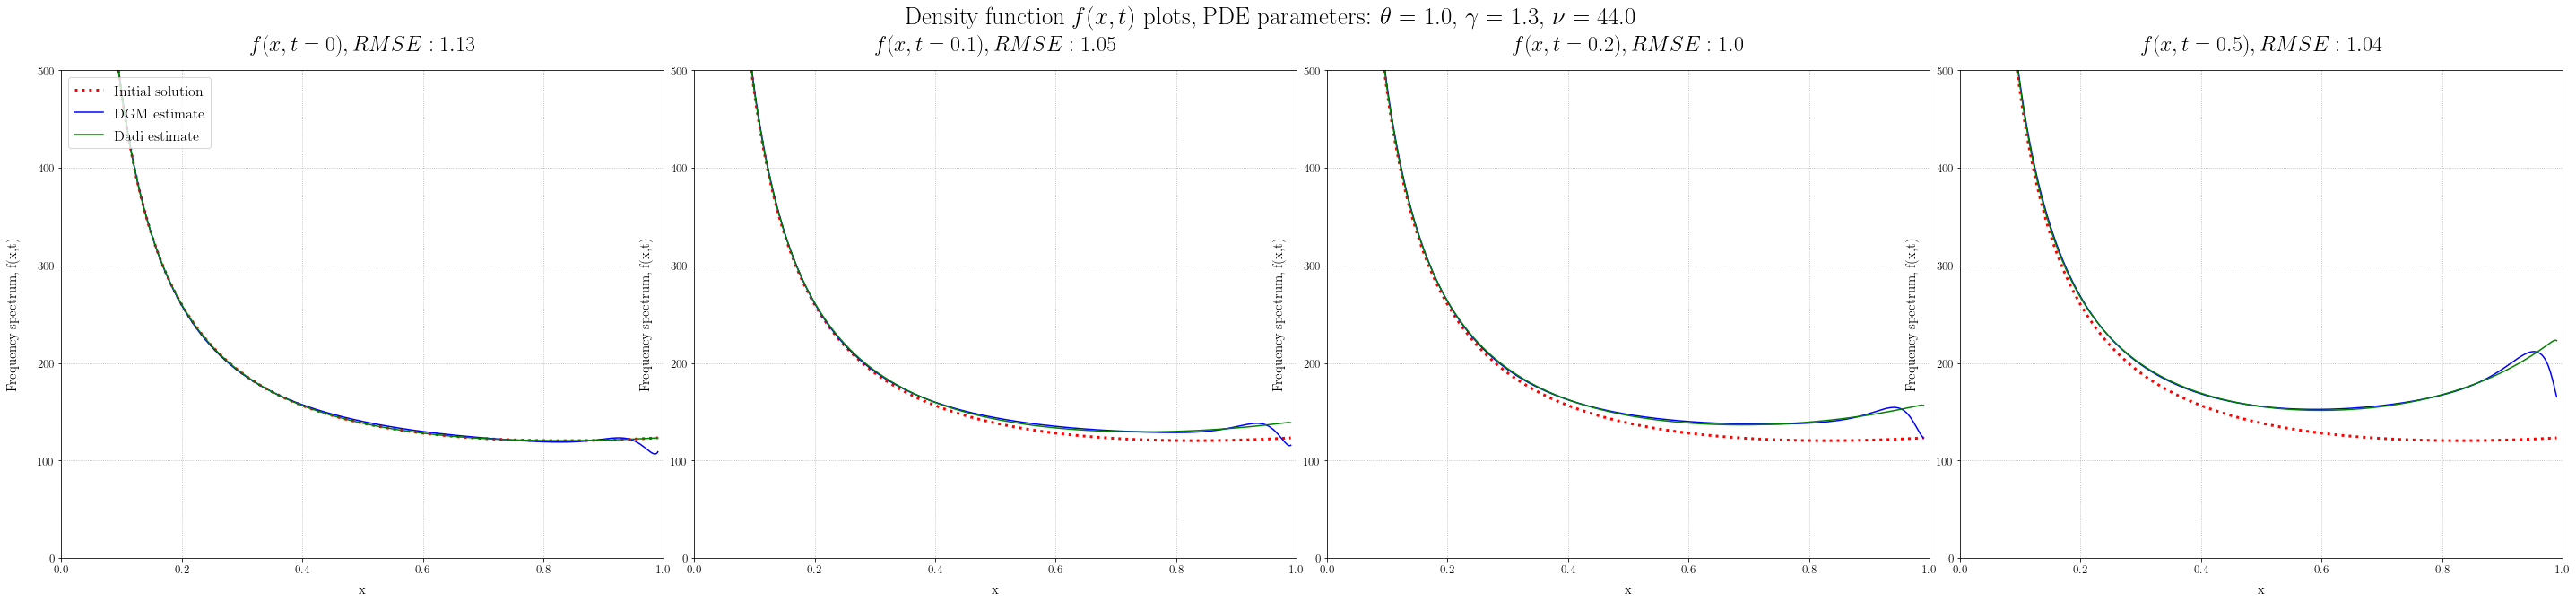

<Figure size 432x288 with 0 Axes>

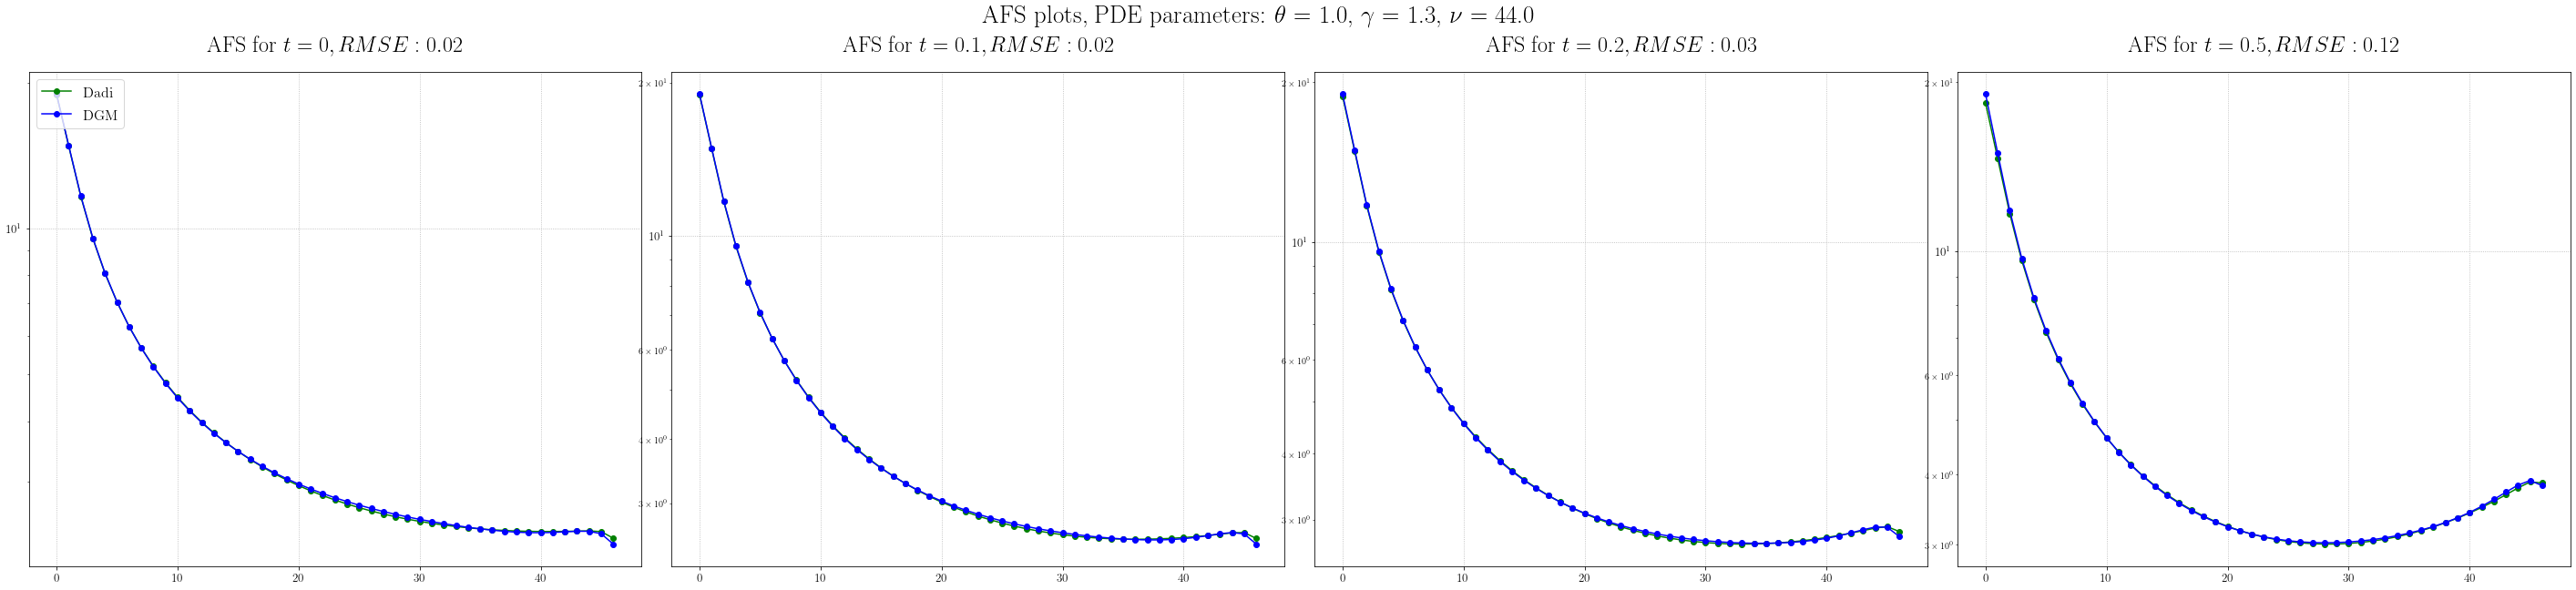

In [23]:
PlotSolutions(theta = 1.0, gamma =  1.3, nu = 44.0)
PlotSolutions(1.0, 1.3, 44.0, plot_afs=True)

### $\gamma = 1.3, \nu = 50.0$

<Figure size 432x288 with 0 Axes>

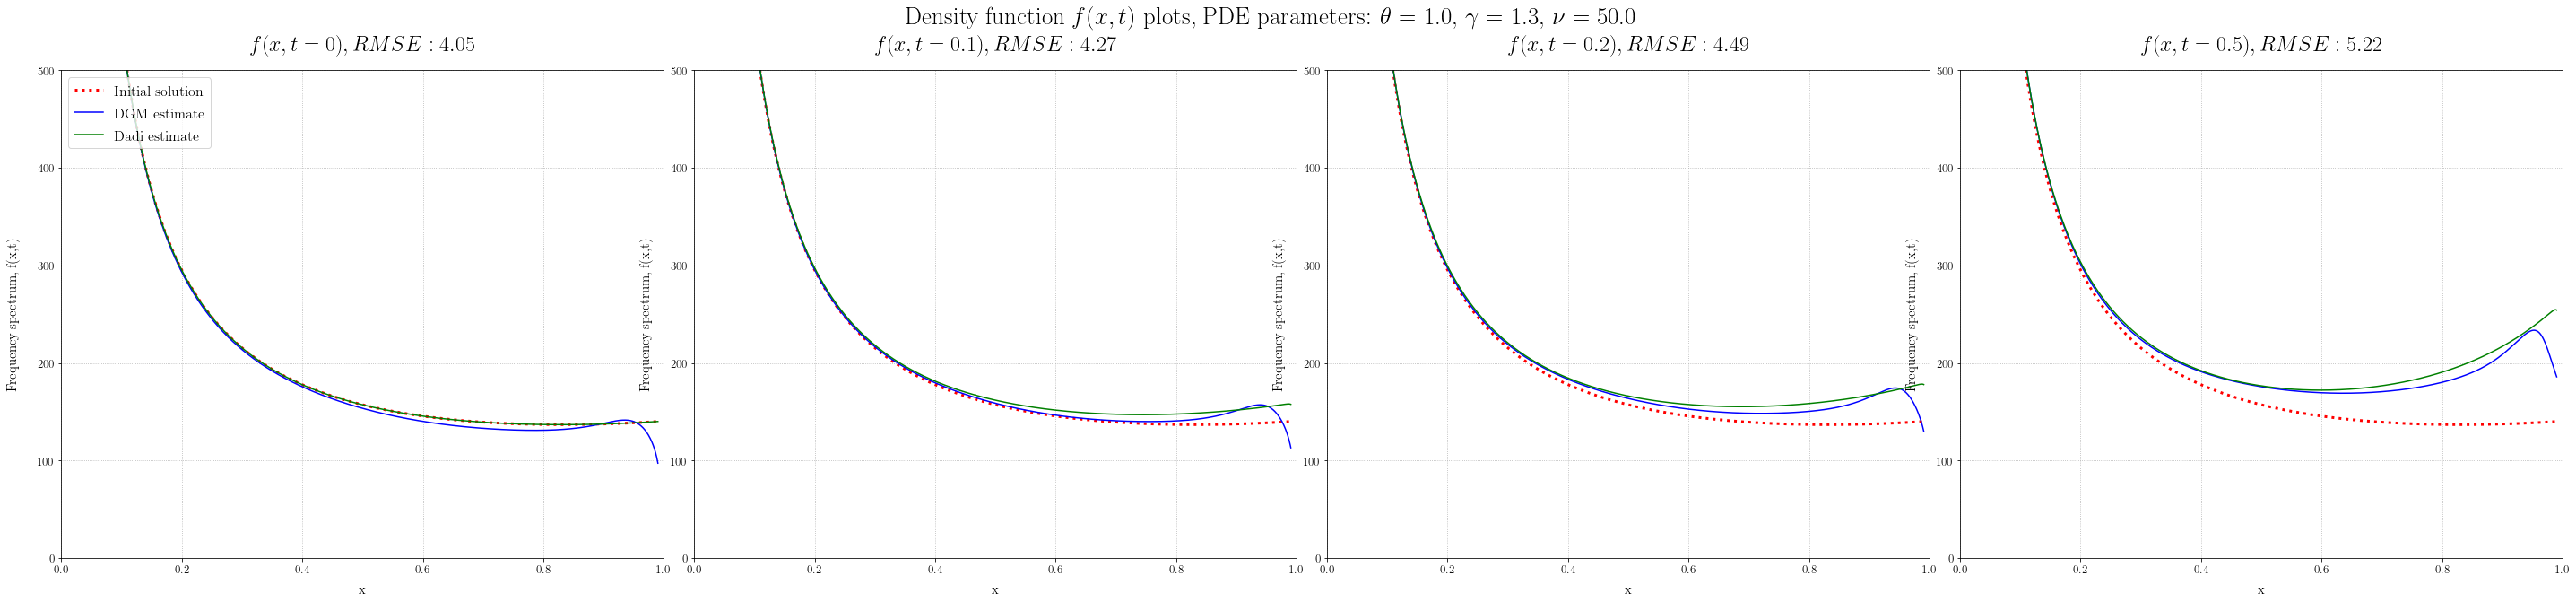

<Figure size 432x288 with 0 Axes>

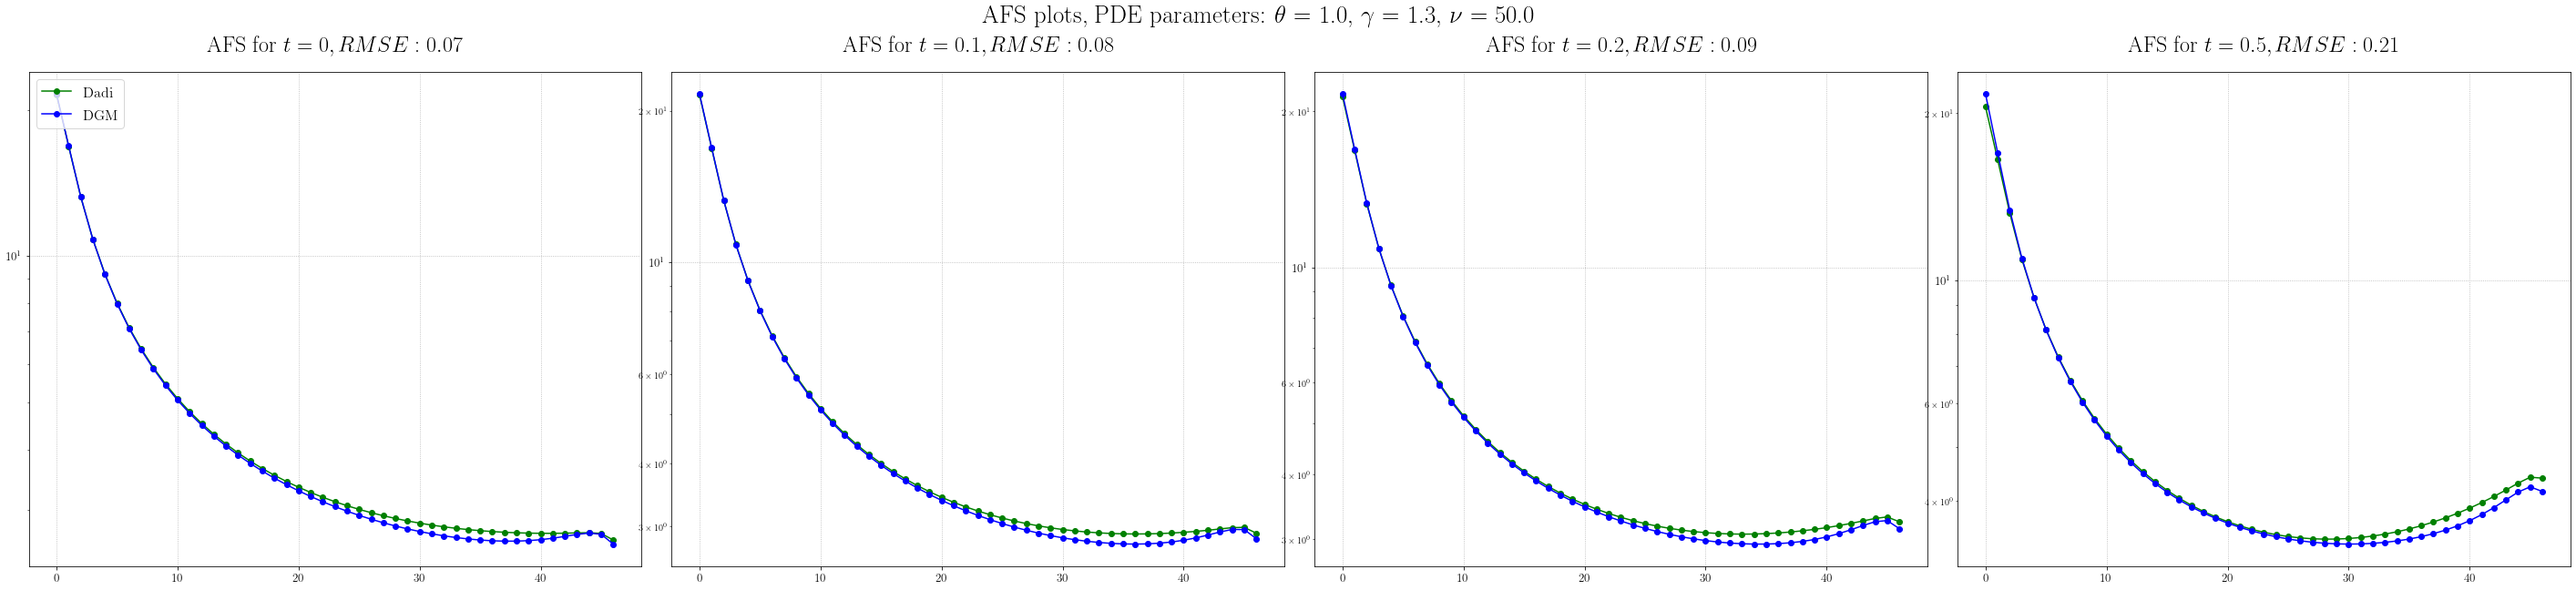

In [24]:
PlotSolutions(theta = 1.0, gamma =  1.3, nu = 50.0)
PlotSolutions(1.0, 1.3, 50.0, plot_afs=True)

### $\gamma = -1.0, \nu = 44.0$

<Figure size 432x288 with 0 Axes>

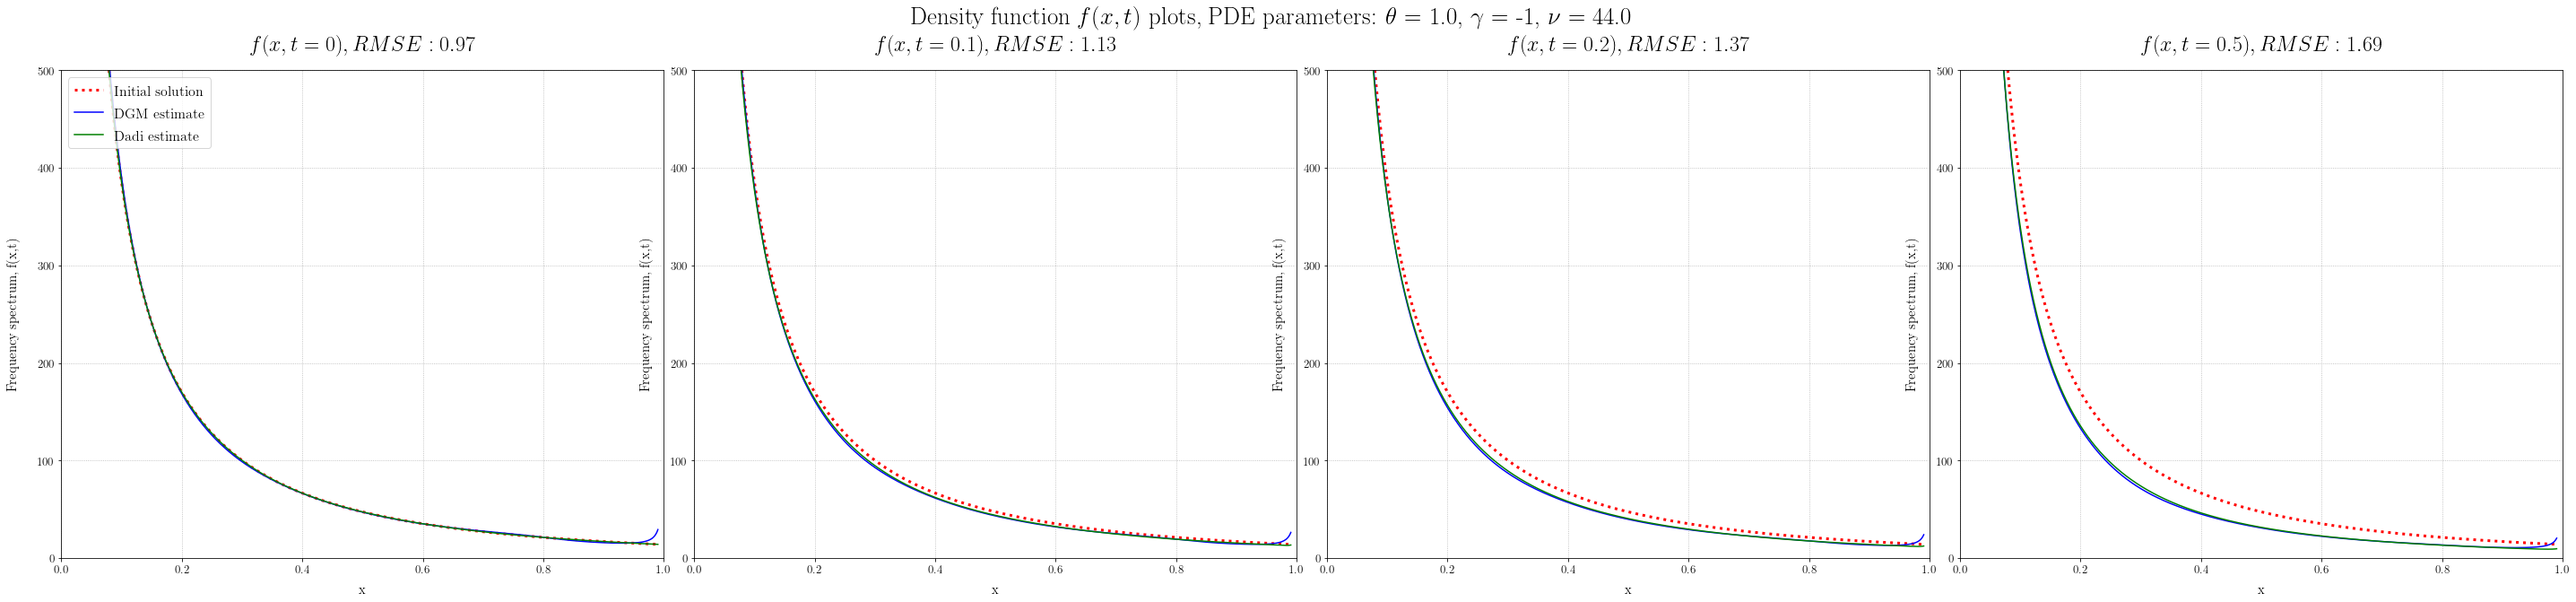

<Figure size 432x288 with 0 Axes>

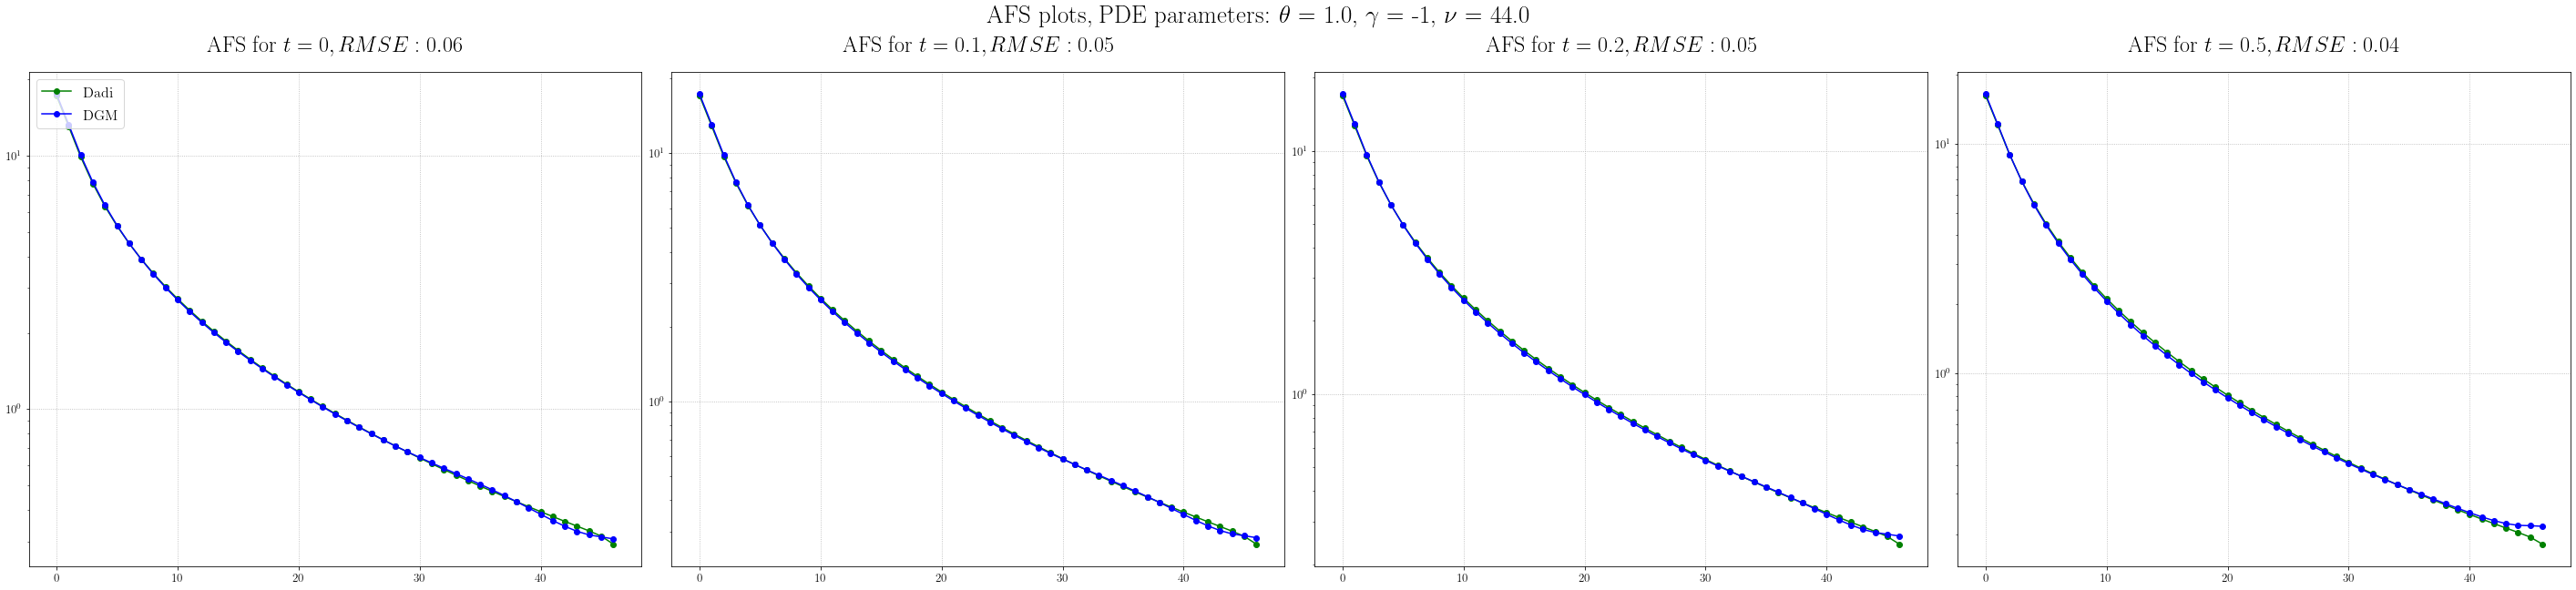

In [27]:
PlotSolutions(theta = 1.0, gamma =  -1, nu = 44.0)
PlotSolutions(1.0, -1, 44.0, plot_afs=True)

### $\gamma = -0.5, \nu = 45.0$

<Figure size 432x288 with 0 Axes>

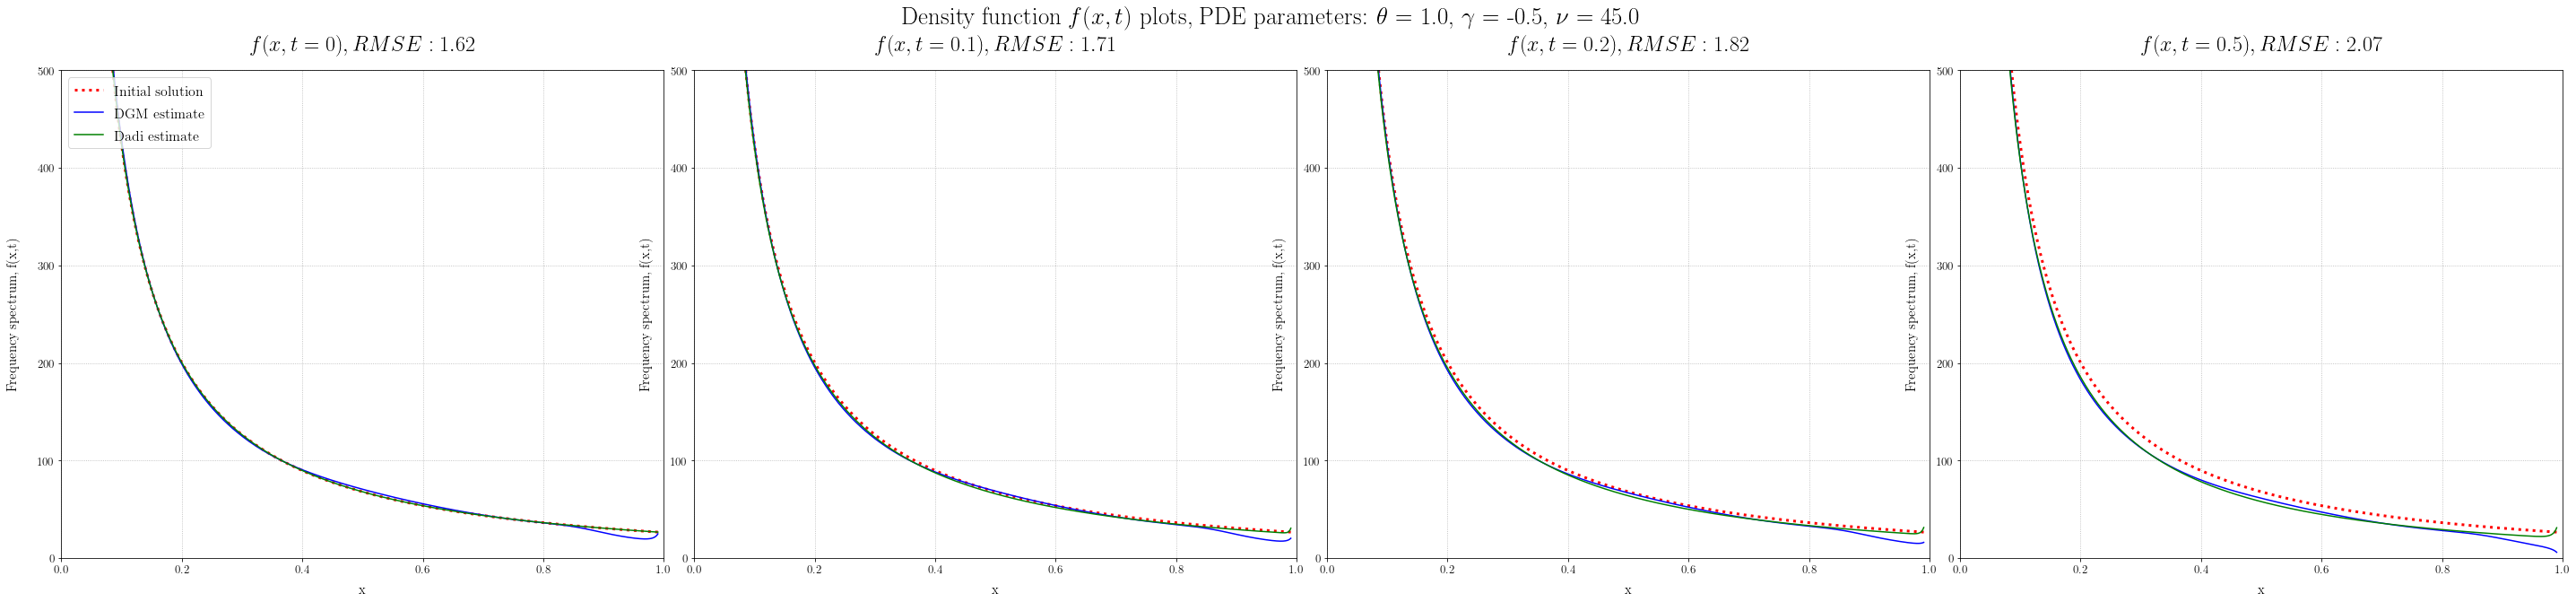

<Figure size 432x288 with 0 Axes>

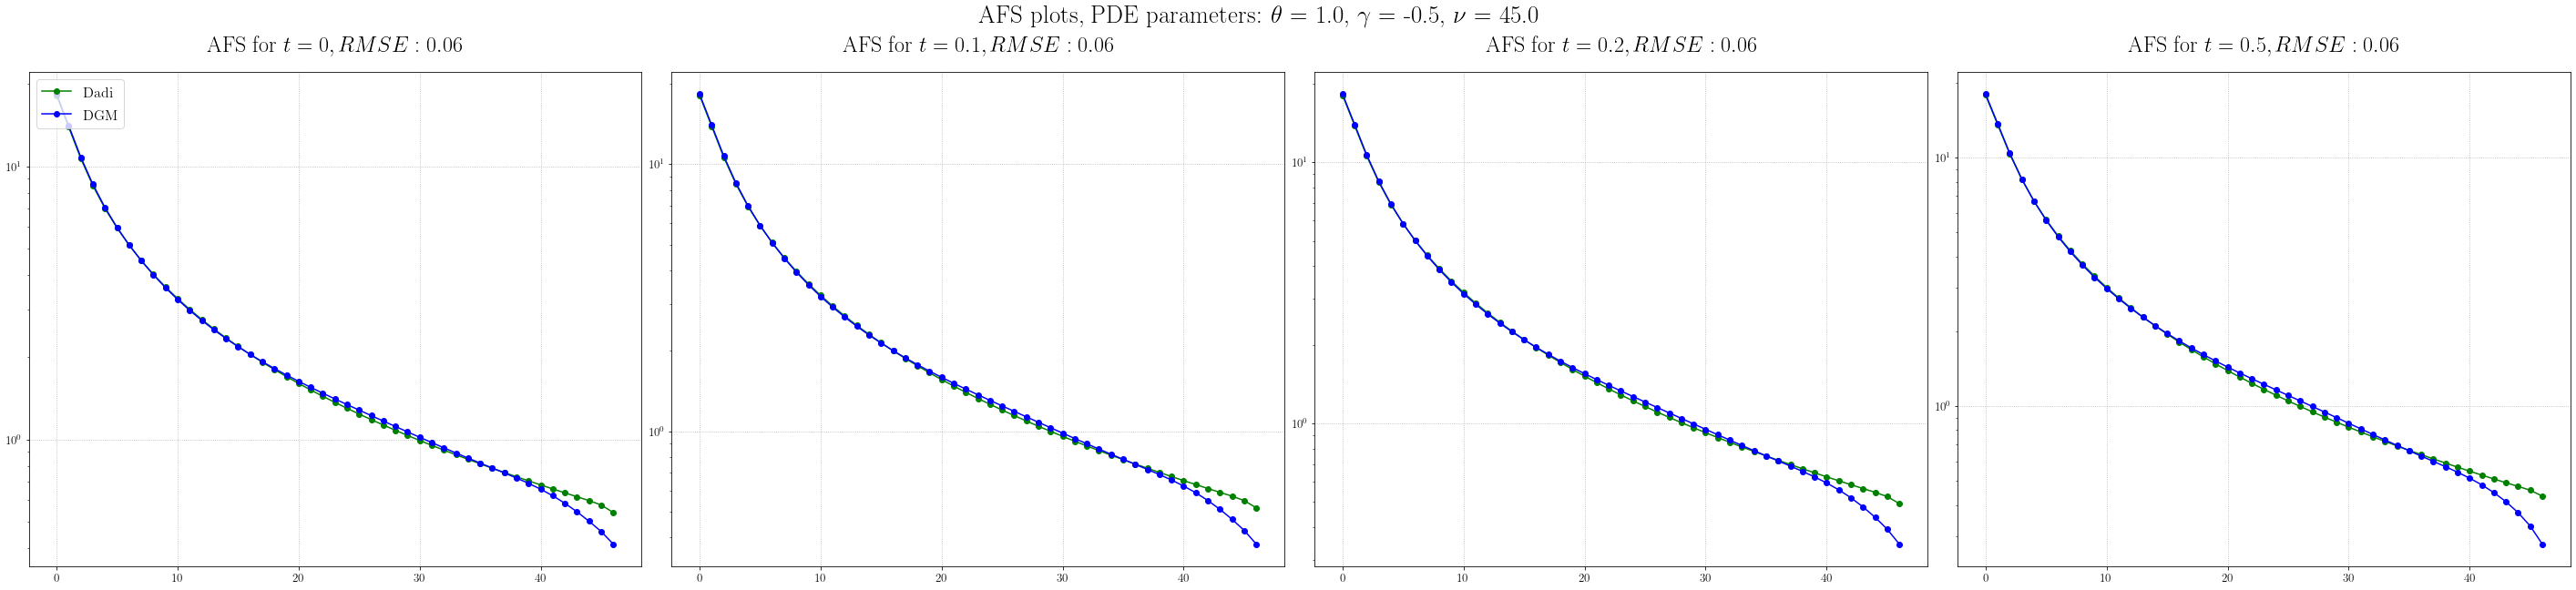

In [31]:
PlotSolutions(theta = 1.0, gamma =  -0.5, nu = 45.0)
PlotSolutions(1.0, -0.5, 45.0, plot_afs=True)